In [1]:
# Install packages if needed with this command: 
#!pip install -r requirements.txt

import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code

# 1. Load dataset


In [2]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset', 
                                    path=data_dir, unzip=True)

In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f: 
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f: 
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]), 
                                label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f: 
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]), 
                               label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f: 
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]), 
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


# 2. Visualise data and plot data distribution

**TASK 1**

**Convert the target values using the proper function for one hot encoding.**

This code processes categorical labels for a driver inattention detection dataset, converting them into a format suitable for deep learning. It first creates a mapping of class names to integer values, replacing text labels (e.g., 'SafeDriving', 'Distracted') with corresponding numeric representations. These integer labels are then transformed into one-hot encoded vectors using TensorFlow's to_categorical function, where each class is represented by a binary vector with a single 1 at the corresponding index. The code ensures that training, validation, and test datasets have properly formatted labels for multi-class classification. Finally, it prints sample converted labels and their one-hot encoded representations to verify the transformation. This preprocessing step is essential for training a neural network, as it allows categorical labels to be efficiently used in a classification model.

In [5]:
# 1.Convert the target values using the proper function for one hot encoding.

from tensorflow.keras.utils import to_categorical

# Create a mapping of class names to integer values
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

# Convert labels from string to integer using mapping
df_train['label'] = df_train['label'].map(class_mapping)
df_val['label'] = df_val['label'].map(class_mapping)
df_test['label'] = df_test['label'].map(class_mapping)

# Check if the conversion was successful
print("Class mapping:", class_mapping)
print("Sample converted labels:\n", df_train['label'].head())

# Apply one-hot encoding
num_classes = len(classes)
train_labels = to_categorical(df_train['label'], num_classes=num_classes)
val_labels = to_categorical(df_val['label'], num_classes=num_classes)
test_labels = to_categorical(df_test['label'], num_classes=num_classes)

# Print to verify one-hot encoding
print("Sample one-hot labels for training data:\n", train_labels[:5])

Class mapping: {'DangerousDriving': 0, 'Distracted': 1, 'Drinking': 2, 'SafeDriving': 3, 'SleepyDriving': 4, 'Yawn': 5}
Sample converted labels:
 0    3
1    3
2    2
3    0
4    3
Name: label, dtype: int64
Sample one-hot labels for training data:
 [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


**TASK 2**

**Visualise data and plot data distribution**

Randomly select 15 samples from the dataset. For each selected sample, display the image along with its corresponding label as text on top of the image. Arrange 2 these images and labels in a single figure, ensuring that they are visually clear and labeled properly.

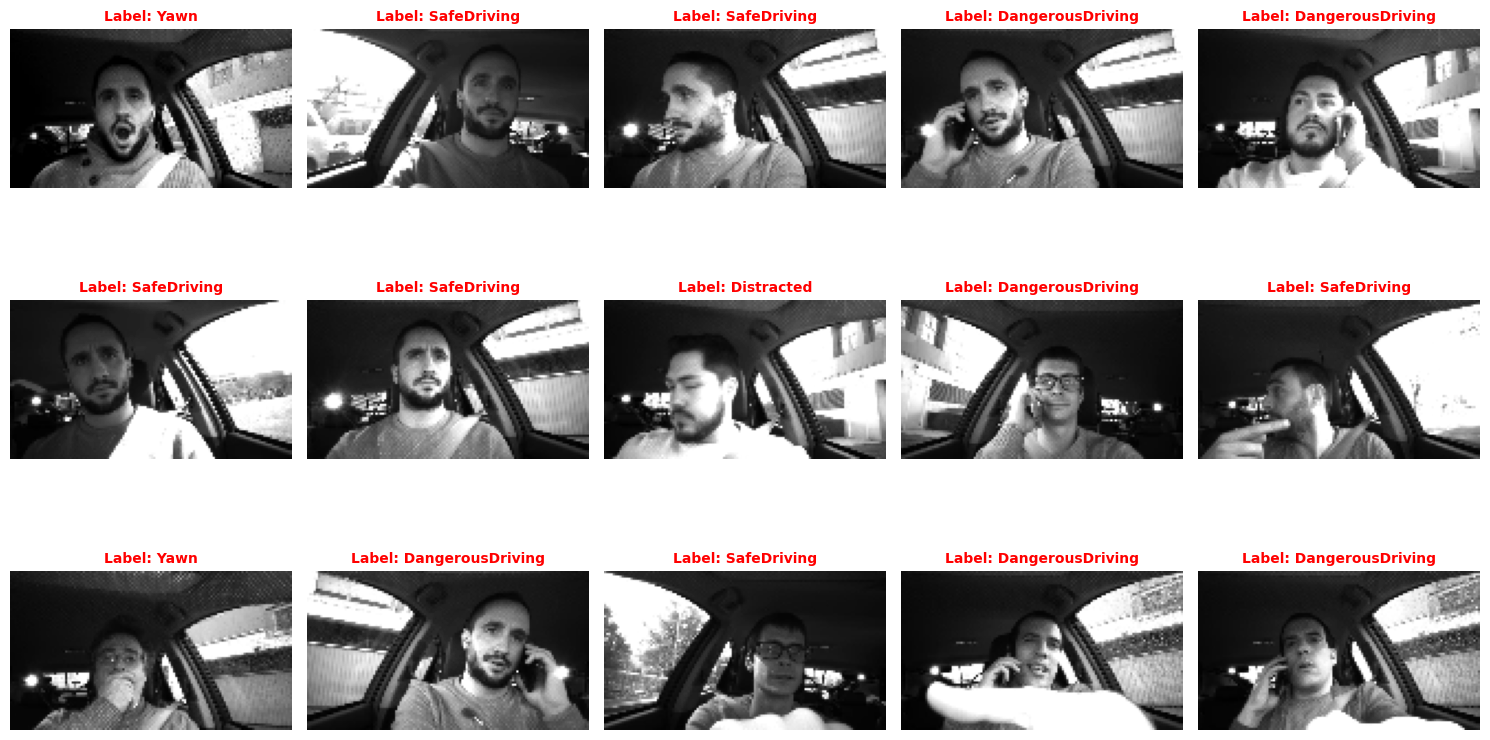

In [6]:
import matplotlib.pyplot as plt
import random
import cv2

# Select 15 random samples from the training dataset
sample_indices = random.sample(range(len(df_train)), 15)
sample_images = df_train.iloc[sample_indices]

# Create a figure to display the images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Arrange in a 3x5 grid

for ax, (_, row) in zip(axes.flat, sample_images.iterrows()):
    img = cv2.imread(row['img'], cv2.IMREAD_GRAYSCALE)  # Load grayscale image
    img = cv2.resize(img, (128, 72))  # Resize to match training dimensions

    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {classes[row['label']]}", fontsize=10, color='red', fontweight='bold')  # Display class name
    ax.axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

**TASK 3**

**Train and Evaluation functions**

Create a bar plot to visualize the class label distribution of the dataset. (Hint: this bar plot reveals how many samples the dataset has for each class)

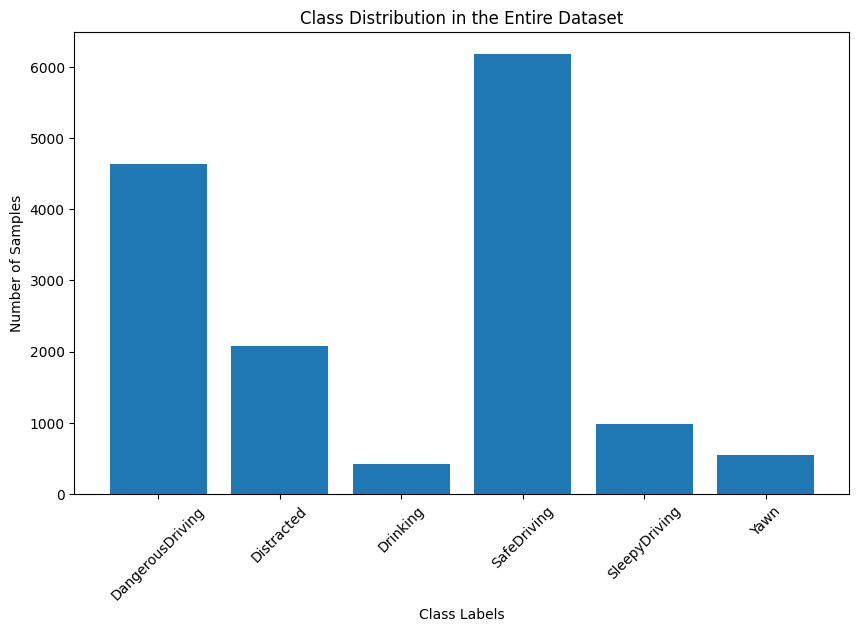

In [7]:
import matplotlib.pyplot as plt

# Count the number of samples per class in the entire dataset (train, validation, and test combined)
total_counts = (
    df_train['label'].value_counts().add(df_val['label'].value_counts(), fill_value=0)
    .add(df_test['label'].value_counts(), fill_value=0)
    .sort_index()
)

# Create a bar plot for class distribution in the entire dataset
plt.figure(figsize=(10, 6))
plt.bar(total_counts.index, total_counts.values, tick_label=[classes[i] for i in total_counts.index])

# Add labels and title
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in the Entire Dataset")
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Show the plot
plt.show()

**TASK 4, 5 & TASK 6**

**BASELINE MODEL AND TRAIN**


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# ================================
# 1. Define and Compile the EXACT Baseline CNN Model
# ================================

model = tf.keras.Sequential()

# First Convolutional Block (8 filters, 3x3 kernel)
model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu',
                                 input_shape=(img_height, img_width, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Second Convolutional Block (8 filters, 3x3 kernel)
model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Third Convolutional Block (8 filters, 3x3 kernel)
model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Flatten and Fully Connected Layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))   # Corrected: Should be 10, NOT 784
model.add(tf.keras.layers.Dense(6, activation='softmax'))  # Output layer (6 classes)

# Compile the Model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# =================================
# 2. Display Model Summary
# =================================

print("\n🔹 Baseline Model Summary:\n")
model.summary()  # Print model summary in text format

# =================================
# 3. Train the Model (EXACTLY 10 EPOCHS)
# =================================

history = model.fit(
    train_data,
    validation_data=val_data, #Validation set used here - >  TASK 4: monitoring model performance on the validation set during training to track overfitting or underfitting.
    epochs=10,  # REQUIRED: 10 epochs
    verbose=1
)

# =================================


🔹 Baseline Model Summary:



C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 126, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 61, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 14, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.4148 - loss: 1.4347 - val_accuracy: 0.6015 - val_loss: 1.1140
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.5986 - loss: 1.0703 - val_accuracy: 0.7071 - val_loss: 0.8461
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6998 - loss: 0.8349 - val_accuracy: 0.7341 - val_loss: 0.7330
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7426 - loss: 0.7303 - val_accuracy: 0.7471 - val_loss: 0.6967
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.7573 - loss: 0.6850 - val_accuracy: 0.7758 - val_loss: 0.6458
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.7801 - loss: 0.6370 - val_accuracy: 0.7294 - val_loss: 0.7637
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7849 - loss: 0.5969 - val_accuracy: 0.8018 - val_loss: 0.5684
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8070 - loss: 0.5581 - 

**TASK 7**

**Analyze the performance of the baseline by plotting**

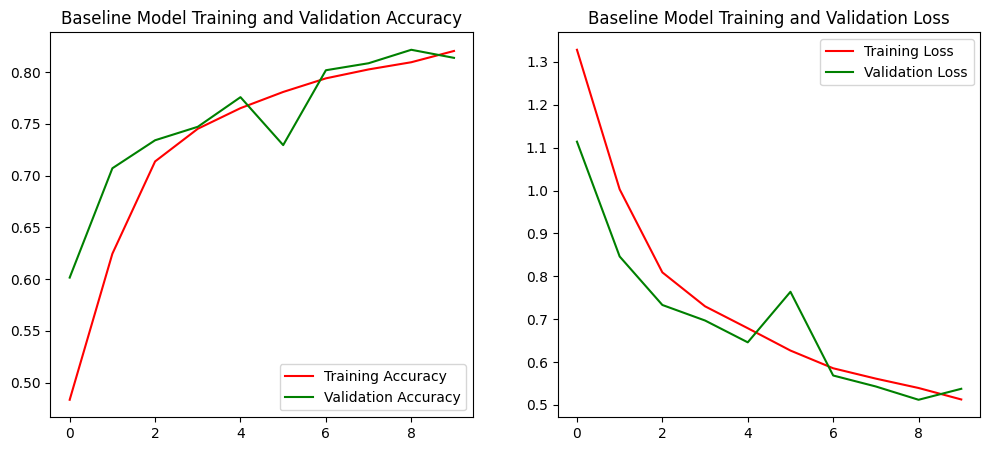

C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8230 - loss: 0.5162

🔹 Test Accuracy: 0.82
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step


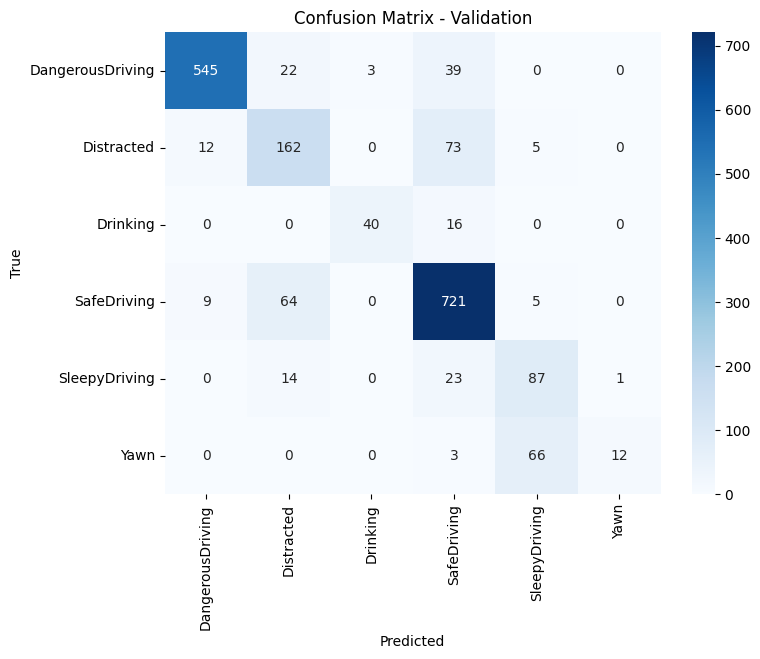


🔹 Classification Report for Validation Set:
                   precision    recall  f1-score   support

DangerousDriving       0.96      0.89      0.93       609
      Distracted       0.62      0.64      0.63       252
        Drinking       0.93      0.71      0.81        56
     SafeDriving       0.82      0.90      0.86       799
   SleepyDriving       0.53      0.70      0.60       125
            Yawn       0.92      0.15      0.26        81

        accuracy                           0.82      1922
       macro avg       0.80      0.67      0.68      1922
    weighted avg       0.83      0.82      0.81      1922



C:\Users\paolo\AppData\Local\Temp\ipykernel_21960\1671678097.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='black')  # Random Guess line


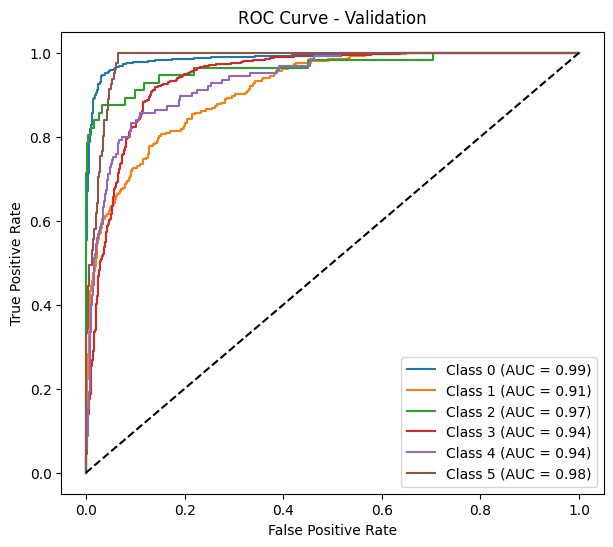

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


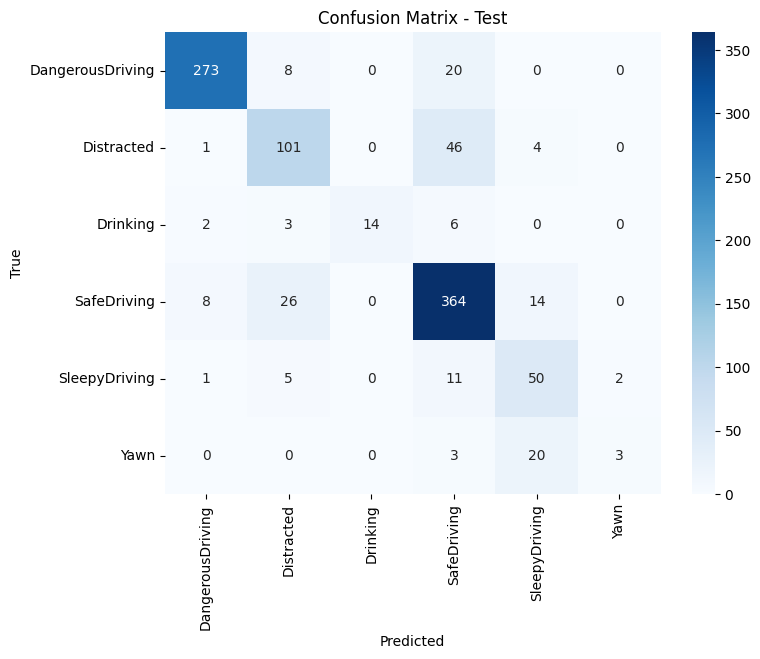


🔹 Classification Report for Test Set:
                   precision    recall  f1-score   support

DangerousDriving       0.96      0.91      0.93       301
      Distracted       0.71      0.66      0.68       152
        Drinking       1.00      0.56      0.72        25
     SafeDriving       0.81      0.88      0.84       412
   SleepyDriving       0.57      0.72      0.64        69
            Yawn       0.60      0.12      0.19        26

        accuracy                           0.82       985
       macro avg       0.77      0.64      0.67       985
    weighted avg       0.82      0.82      0.81       985



C:\Users\paolo\AppData\Local\Temp\ipykernel_21960\1671678097.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='black')  # Random Guess line


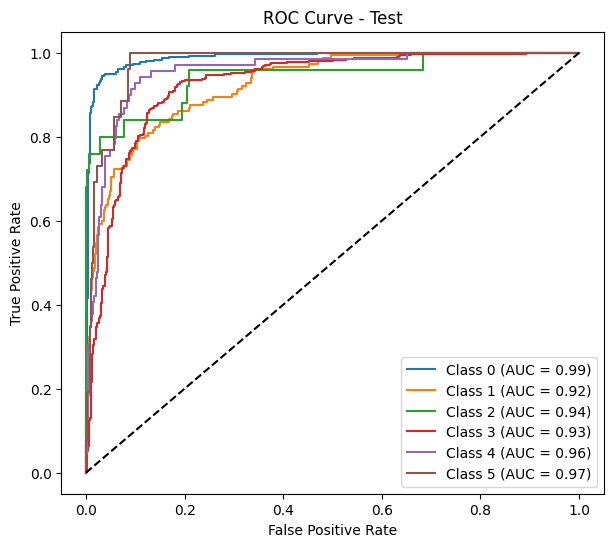

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

# ================================
# 4. Plot Training & Validation Performance
# ================================

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.legend(loc='lower right')
plt.title('Baseline Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.legend(loc='upper right')
plt.title('Baseline Model Training and Validation Loss')

plt.show()

# ================================
# 5. Evaluate Model on Test Data
# ================================
test_loss, test_acc = model.evaluate(test_data)
print(f"\n🔹 Test Accuracy: {test_acc:.2f}")

# ================================
# 6. Compute Performance Metrics (Validation & Test)
# ================================

def evaluate_model(model, dataset, dataset_name):
    # Extract true labels
    y_true = np.array(dataset.classes)  # Correct extraction of labels
    y_pred_prob = model.predict(dataset)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    # Compute Classification Report
    report = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
    print(f"\n🔹 Classification Report for {dataset_name} Set:\n", report)

    # Compute ROC Curves and AUC Scores
    plt.figure(figsize=(7, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', color='black')  # Random Guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend()
    plt.show()

# Evaluate on Validation Set
evaluate_model(model, val_data, "Validation") # Explicit validation performance check (Task 4 comply.)

# Evaluate on Test Set
evaluate_model(model, test_data, "Test")

**and now...**

In [8]:
import tensorflow as tf

model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(
    23, (2, 2), activation='tanh', padding="SAME", input_shape=(img_height, img_width, 1)
))


model.add(tf.keras.layers.Conv2D(
    28, (2, 2), activation='relu', padding="SAME"
))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


model.add(tf.keras.layers.Conv2D(
    19, (2, 2), activation='tanh', padding="SAME"
))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


model.add(tf.keras.layers.Conv2D(
    16, (2, 2), activation='tanh', padding="SAME"
))


model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(114, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.5))  


model.add(tf.keras.layers.Dense(6, activation='softmax'))


optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0003167687053337831)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()


C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 72, 128, 23)    │           115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 128, 28)    │         2,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 64, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 64, 19)     │         2,147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 32, 19)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 32, 16)     │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 114)            │     1,050,738 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 114)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057,526 (4.03 MB)

 Trainable params: 1,057,526 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_data,
    validation_data=val_data, 
    epochs=15,  
    verbose=1
)

Epoch 1/15


C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.5423 - loss: 1.1859 - val_accuracy: 0.7799 - val_loss: 0.6836
Epoch 2/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.7320 - loss: 0.7344 - val_accuracy: 0.7945 - val_loss: 0.6043
Epoch 3/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.7804 - loss: 0.6157 - val_accuracy: 0.8236 - val_loss: 0.5334
Epoch 4/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.8035 - loss: 0.5550 - val_accuracy: 0.8304 - val_loss: 0.5100
Epoch 5/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.8182 - loss: 0.5215 - val_accuracy: 0.8413 - val_loss: 0.4896
Epoch 6/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 51s 137ms/step - accuracy: 0.8270 - loss: 0.4854 - val_accuracy: 0.8491 - val_loss: 0.4679
Epoch 7/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 51s 137ms/step - accuracy: 0.8466 - loss: 0.4408 - val_accuracy: 0.8585 - val_loss: 0.4375
Epoch 8/15
374/374 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.8479 - loss: 0.4213 - val_ac

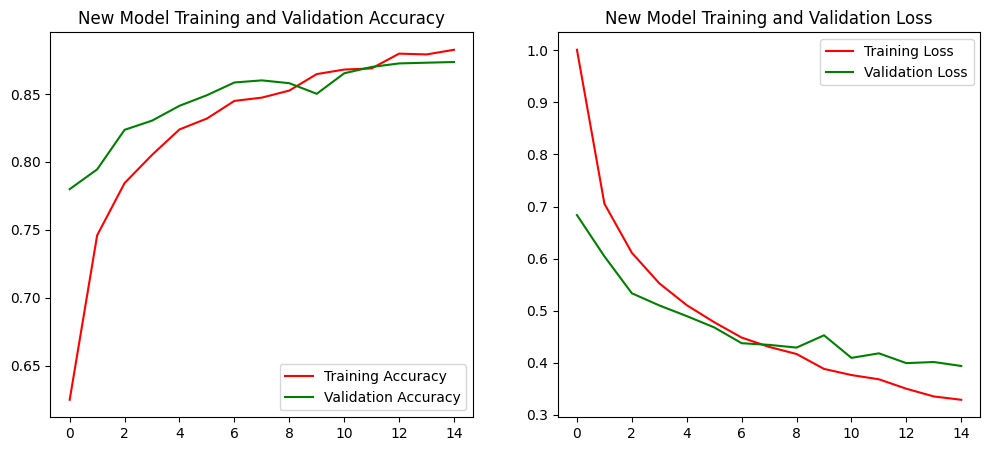

 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8125 - loss: 0.6460

C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8622 - loss: 0.4161

🔹 Test Accuracy: 0.86
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


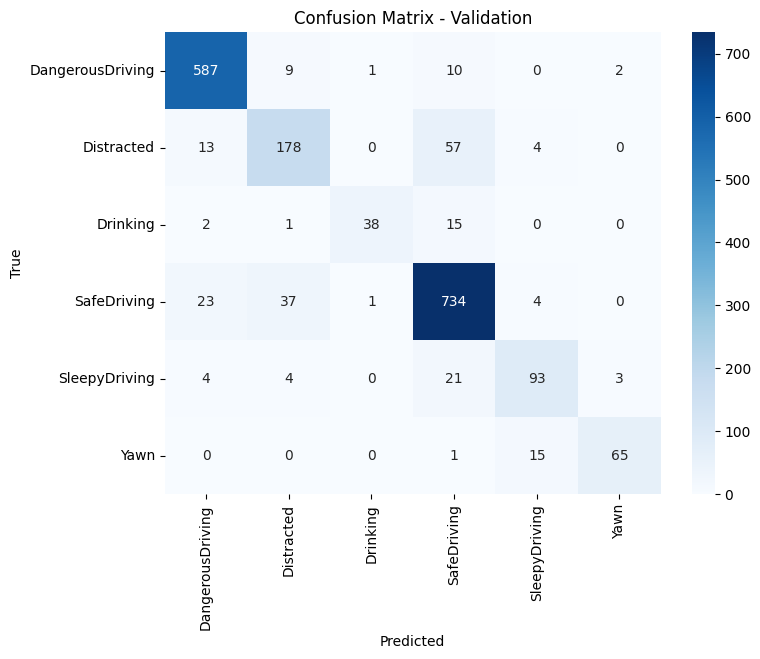


🔹 Classification Report for Validation Set:
                   precision    recall  f1-score   support

DangerousDriving       0.93      0.96      0.95       609
      Distracted       0.78      0.71      0.74       252
        Drinking       0.95      0.68      0.79        56
     SafeDriving       0.88      0.92      0.90       799
   SleepyDriving       0.80      0.74      0.77       125
            Yawn       0.93      0.80      0.86        81

        accuracy                           0.88      1922
       macro avg       0.88      0.80      0.83      1922
    weighted avg       0.88      0.88      0.88      1922



C:\Users\paolo\AppData\Local\Temp\ipykernel_12808\2821847733.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='black')  # Random Guess line


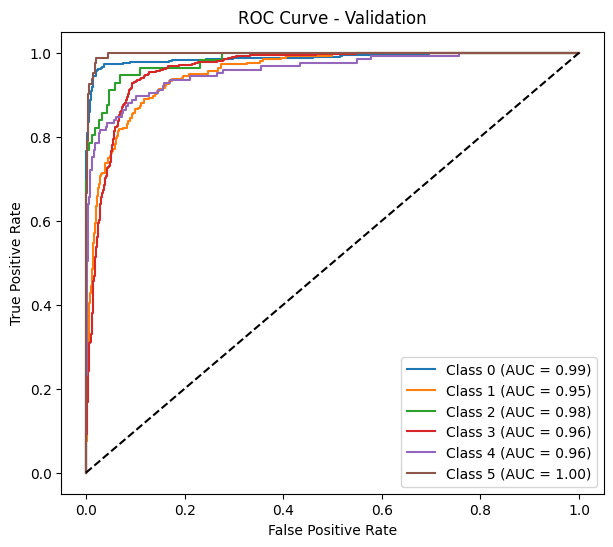

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


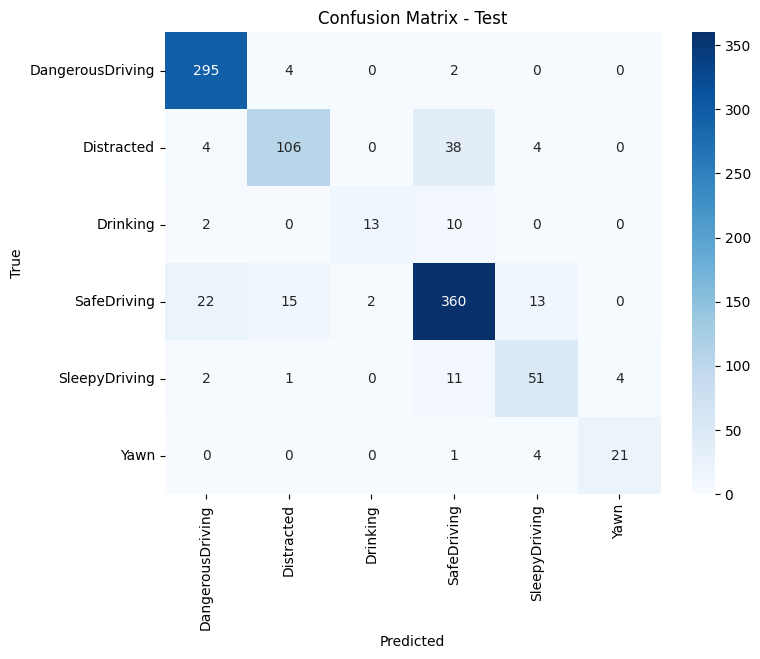


🔹 Classification Report for Test Set:
                   precision    recall  f1-score   support

DangerousDriving       0.91      0.98      0.94       301
      Distracted       0.84      0.70      0.76       152
        Drinking       0.87      0.52      0.65        25
     SafeDriving       0.85      0.87      0.86       412
   SleepyDriving       0.71      0.74      0.72        69
            Yawn       0.84      0.81      0.82        26

        accuracy                           0.86       985
       macro avg       0.84      0.77      0.79       985
    weighted avg       0.86      0.86      0.86       985



C:\Users\paolo\AppData\Local\Temp\ipykernel_12808\2821847733.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='black')  # Random Guess line


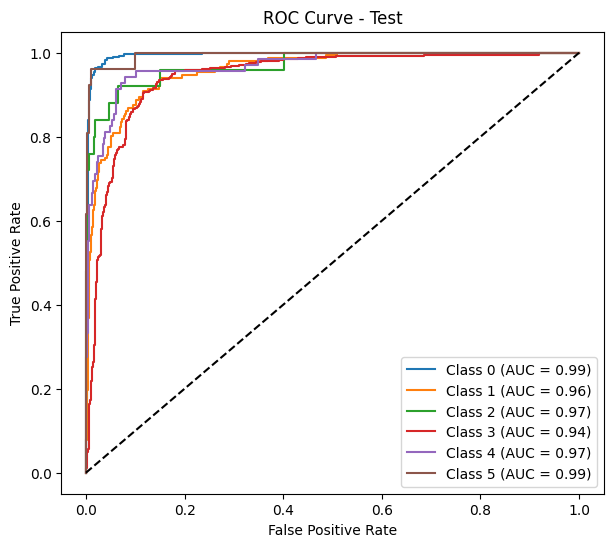

In [10]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.legend(loc='lower right')
plt.title('New Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.legend(loc='upper right')
plt.title('New Model Training and Validation Loss')

plt.show()

# ================================
# 5. Evaluate Model on Test Data
# ================================
test_loss, test_acc = model.evaluate(test_data)
print(f"\n🔹 Test Accuracy: {test_acc:.2f}")

# ================================
# 6. Compute Performance Metrics (Validation & Test)
# ================================

def evaluate_model(model, dataset, dataset_name):
    # Extract true labels
    y_true = np.array(dataset.classes)  # Correct extraction of labels
    y_pred_prob = model.predict(dataset)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    # Compute Classification Report
    report = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
    print(f"\n🔹 Classification Report for {dataset_name} Set:\n", report)

    # Compute ROC Curves and AUC Scores
    plt.figure(figsize=(7, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', color='black')  # Random Guess line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend()
    plt.show()

# Evaluate on Validation Set
evaluate_model(model, val_data, "Validation") # Explicit validation performance check (Task 4 comply.)

# Evaluate on Test Set
evaluate_model(model, test_data, "Test")